# Preparing the Environment
In this kernel, I will use **sklearn** to develop a model and vectorize the texts; **nltk** to preprocess texts and data overview.

And I will use several libraries.

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import time
import re

In [2]:
train_set = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding="latin1")
test_set = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv',encoding="latin1")

train_set.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


# Data Overview
In this section we will take a look at the data. And in order to do this we will use frequency distrubutions of NLTK.

* First let's drop unrelevant features

In [3]:
unrelevant_features = ["UserName","ScreenName","Location","TweetAt"]

train_set.drop(unrelevant_features,inplace=True,axis=1)
test_set.drop(unrelevant_features,inplace=True,axis=1)
train_set.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


* Now let's split sentences as their class, Positive,Neutral and Negative.

In [4]:
train_set["Sentiment"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [5]:
positives = train_set[(train_set["Sentiment"] == "Positive") | (train_set["Sentiment"] == "Extremely Positive")]
positives_test = test_set[(test_set["Sentiment"] == "Positive") | (test_set["Sentiment"] == "Extremely Positive")]
print(positives["Sentiment"].value_counts())
positives.head()


Positive              11422
Extremely Positive     6624
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
5,As news of the regionÂs first confirmed COVID...,Positive
6,Cashier at grocery store was sharing his insig...,Positive


In [6]:
negatives = train_set[(train_set["Sentiment"] == "Negative") | (train_set["Sentiment"] == "Extremely Negative")]
negatives_test = test_set[(test_set["Sentiment"] == "Negative") | (test_set["Sentiment"] == "Extremely Negative")]
print(negatives["Sentiment"].value_counts())
negatives.head()

Negative              9917
Extremely Negative    5481
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
9,"For corona prevention,we should stop to buy th...",Negative
20,with 100 nations inficted with covid 19 th...,Extremely Negative
24,@10DowningStreet @grantshapps what is being do...,Negative
26,In preparation for higher demand and a potenti...,Negative


In [7]:
neutrals = train_set[train_set["Sentiment"] == "Neutral"]
neutrals_test = test_set[test_set["Sentiment"] == "Neutral"]
print(neutrals["Sentiment"].value_counts())
neutrals.head()

Neutral    7713
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
7,Was at the supermarket today. Didn't buy toile...,Neutral
10,All month there hasn't been crowding in the su...,Neutral
16,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,Neutral
17,@eyeonthearctic 16MAR20 Russia consumer survei...,Neutral


* Now let's convert labels into integers, I will label negatives as 0, neutrals as 1 and positives as 2.

In [8]:
import warnings as wrn
wrn.filterwarnings('ignore')

negatives["Sentiment"] = 0 
negatives_test["Sentiment"] = 0

positives["Sentiment"] = 2
positives_test["Sentiment"] = 2

neutrals["Sentiment"] = 1
neutrals_test["Sentiment"] = 1

negatives.head()

,OriginalTweet,Sentiment
4,"Me, ready to go at supermarket during the #COV...",0
9,"For corona prevention,we should stop to buy th...",0
20,with 100 nations inficted with covid 19 th...,0
24,@10DowningStreet @grantshapps what is being do...,0
26,In preparation for higher demand and a potenti...,0


* Now I will concatenate train and test, I will split them after processing.

In [9]:
data = pd.concat([positives,
                  positives_test,
                  neutrals,
                  neutrals_test,
                  negatives,
                  negatives_test
                 ],axis=0)

data.reset_index(inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          44955 non-null  int64 
 1   OriginalTweet  44955 non-null  object
 2   Sentiment      44955 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [11]:
data.head()

,index,OriginalTweet,Sentiment
0,1,advice Talk to your neighbours family to excha...,2
1,2,Coronavirus Australia: Woolworths to give elde...,2
2,3,My food stock is not the only one which is emp...,2
3,5,As news of the regionÂs first confirmed COVID...,2
4,6,Cashier at grocery store was sharing his insig...,2


* Finally everything is ready, we can start examining data with examining random texts.

In [12]:
import random
for i in range(1,10):
    random_ind = random.randint(0,len(data))
    print(str(data["OriginalTweet"][random_ind]),end="\nLabel: ")
    print(str(data["Sentiment"][random_ind]),end="\n\n")


A friend asked how things were at the grocery store...I never go to a grocery store on a weekend period, never mind during a #coronavirus #pandemic or even an #apocalypse #thatswhack
Label: 2






 https://t.co/UhdqMidvvH
Label: 0

We have crazy Samsung deals guys Get the Note 10 230 000 Note 9 140000 S9 140 000 You cannot get this prices anywhere else  
Label: 0

The is singing the praises of grocery store clerks and delivery drivers as some of the frontline heroes of this outbreak Those people deserve more than hollow praise They deserve a national 15 hr minimum wage and quality healthcare
Label: 2



https://t.co/Ll0MJt2gkn
Label: 0

By Whitney Jakob, ÂDay 11 of corona quarantine...I found a new hobby - toilet people art.Â #toiletpaper #toiletpeopleart #quarantine #selfisolation #artistsoninstagram #installationart #coronavirus #covid_19 https://t.co/zVEce6RLsS
Label: 1

On hold to @sainsburys for 43 mins and counting because we've always done online shopping for self isolating/h

* And let's take a look at the frequency distributions.

In [13]:
positiveFD = nltk.FreqDist(word for text in data[data["Sentiment"] == 2]["OriginalTweet"] for word in text.lower().split())
negativeFD = nltk.FreqDist(word  for text in data[data["Sentiment"] == 0]["OriginalTweet"] for word in text.lower().split())
neutralDF = nltk.FreqDist(word  for text in data[data["Sentiment"] == 1]["OriginalTweet"] for word in text.lower().split())

* And now we can examine most used words plots.

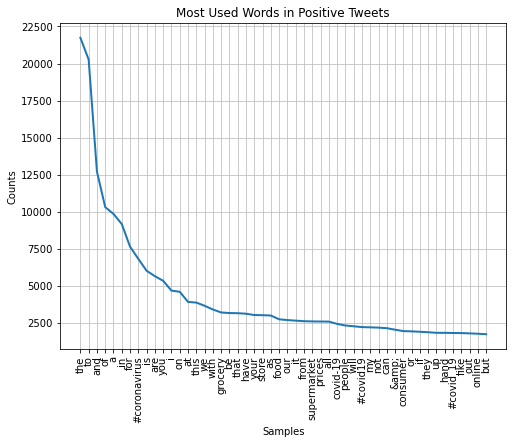

In [16]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Positive Tweets")
positiveFD.plot(50)
plt.show()

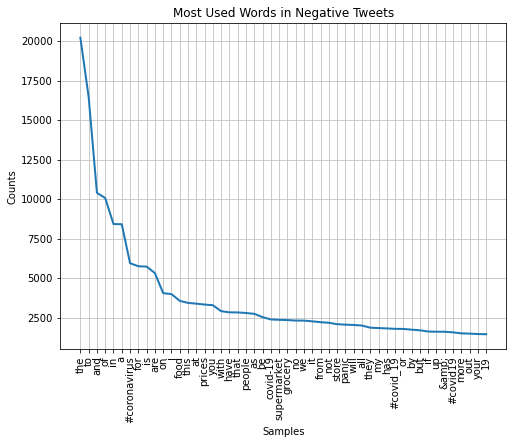

In [17]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Negative Tweets")
negativeFD.plot(50)
plt.show()

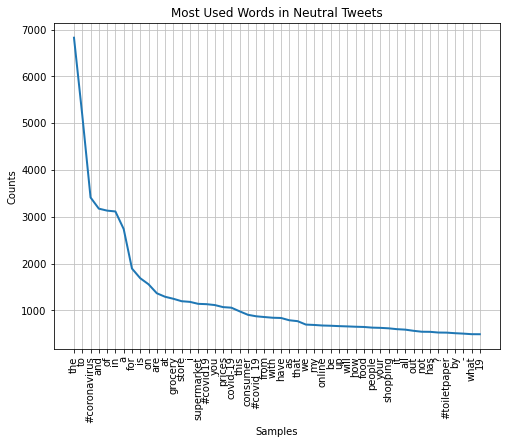

In [19]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Neutral Tweets")
neutralDF.plot(50)
plt.show()

* Although most of the words are same (we say them stopwords [words that not have a special meaning]) we can see characteristic words such as **panic**

# Data Preprocessing
In this section we will prepare the dataset in order to use in SVM model. Before starting I want to explain processes with 1 line explanations

* Cleaning Links: We'll clean all website links using regular expressions
* Cleaning Everything Except Alphabetical and Numerical Characters: We'll clean unrelevant digits using regular expressions
* Tokenizing and Lemmatizing: We'll split texts into their words and convert words to their base form (dogs=>dog)
* Removing Stopwords: We'll remove words that have no special meaning (such as **the,will,was**)
* Joining Prepared Strings: We'll join the words
* Bag of Words Approach: We'll create a bag of word. In bag of words approach each feature shows whether the text contains the word or not. For instance if our text contains **grocery** word, its **grocery** feature will be 1 if not it will be 0.

If you want to learn more detail about them, you can check my Naive Bayes text classification kernel. Here is the link: https://www.kaggle.com/mehmetlaudatekman/filtering-spam-e-mails-power-of-naive-bayes

In [23]:
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data["OriginalTweet"]:
    
    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]
    
    # Joining
    text = " ".join(text)
    
    cleanedData.append(text)

In [26]:
for i in range(0,5):
    print(cleanedData[i],end="\n\n")

advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order

coronavirus australia woolworth give elderly disabled dedicated shopping hour amid covid 19 outbreak

food stock one empty please panic enough food everyone take need stay calm stay safe covid19france covid 19 covid19 coronavirus confinement confinementotal confinementgeneral

news region first confirmed covid 19 case came sullivan county last week people flocked area store purchase cleaning supply hand sanitizer food toilet paper good tim dodson report

cashier grocery store wa sharing insight covid 19 prove credibility commented civics class know talking



* Now we can create our bag of words, but before starting I want to give an example:

        ====TEXT====           HELLO  WORLD  BRO  CLEAN  SOME  TEXT  WELCOME       
        Hello world               1     1     0     0      0     0      0 
        Hello bro                 1     0     1     0      0     0      0
        Clean some text           0     0     0     1      1     1      0
        You're welcome bro        0     0     1     0      0     0      1
        Welcome to world          0     1     0     0      0     0      1
        
This is a simple bag of words model. 

In [27]:
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)


* Everything is ready, we can split our set into train and test.

In [28]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(BOW,np.asarray(data["Sentiment"]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(33716, 10000)
(11239, 10000)
(33716,)
(11239,)


# Support Vector Machine Classifier Modeling
Everything is ready, now ve can fit our classifier.

In [31]:
from sklearn.svm import SVC
start_time = time.time()

model = SVC()
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

Fitting SVC took 755.59 seconds


* It took almost 13 minutes, I hope its worth it.

In [33]:
predictions = model.predict(x_test)

* Now let's take a look at the accuracy and confusion matrix.

In [36]:
from sklearn.metrics import accuracy_score,confusion_matrix

print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))

Accuracy of model is 77.62256428507874%


* Our accuracy is 77% Not bad, but I guess we can develop a better model using deep learning.

# Conclusion
Thanks for your attention. In this kernel I have explained what is SVM and how they work and developing a text classifier using SVMs.

If you have any question in your mind, please ask in comment section.

Have a great day!